# <div style="color:yellow;display:fill;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:90%;letter-spacing:0.5px;margin:0"><b></b>Medical Image Analysis: Predicting Chest CT Scan Results</p></div>


![image](https://storage.googleapis.com/kaggle-datasets-images/3670790/6371090/8c2578d72470a79e5d5c915beeed2879/dataset-cover.png?t=2023-08-27-04-45-44)

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:100%;letter-spacing:0.5px;margin:0"><b></b>Import Libraries</p></div>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from skimage import exposure, transform
from skimage.io import imread

import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:90%;letter-spacing:0.5px;margin:0"><b></b>Define Paths and Image List</p></div>


In [2]:
# define paths and image list
root_dir = '../input/chest-ct-images/CHEST-CT-IMAGES'
root_path = Path(root_dir)
effected_path = root_path / 'EFFECTED'
healthy_path = root_path / 'HEALTHY'
chest_csv = 'Chest-Ct.csv'
images = list(root_path.rglob('*.jpeg'))

# Read the CSV file
csv_data = pd.read_csv('/kaggle/input/chest-ct-images/CHEST-CT-IMAGES/Chest-Ct.csv')

# Map the target values to 'effected' and 'healthy'
csv_data['target'] = csv_data['target'].map({1: 'effected', 0: 'healthy'})

# Extract the Patientid and target columns
patients = csv_data['Patientid']
target_values = csv_data['target']

# Create a DataFrame using the extracted information
df = pd.DataFrame(np.array([images, patients, target_values]).T, columns=['Image path', 'Patient', 'target'])
df.head().style.set_properties(**{'background-color':'royalblue','color':'white','border-color':'#8b8c8c'})


,Image path,Patient,target
0,../input/chest-ct-images/CHEST-CT-IMAGES/EFFECTED/4-E.jpeg,PI15972,effected
1,../input/chest-ct-images/CHEST-CT-IMAGES/EFFECTED/8-E.jpeg,PI15939,effected
2,../input/chest-ct-images/CHEST-CT-IMAGES/EFFECTED/1-E.jpeg,PI15833,healthy
3,../input/chest-ct-images/CHEST-CT-IMAGES/EFFECTED/18-E.jpeg,PI15627,effected
4,../input/chest-ct-images/CHEST-CT-IMAGES/EFFECTED/16-E.jpeg,PI15626,healthy


# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:90%;letter-spacing:0.5px;margin:0"><b></b>Data Visualization</p></div>


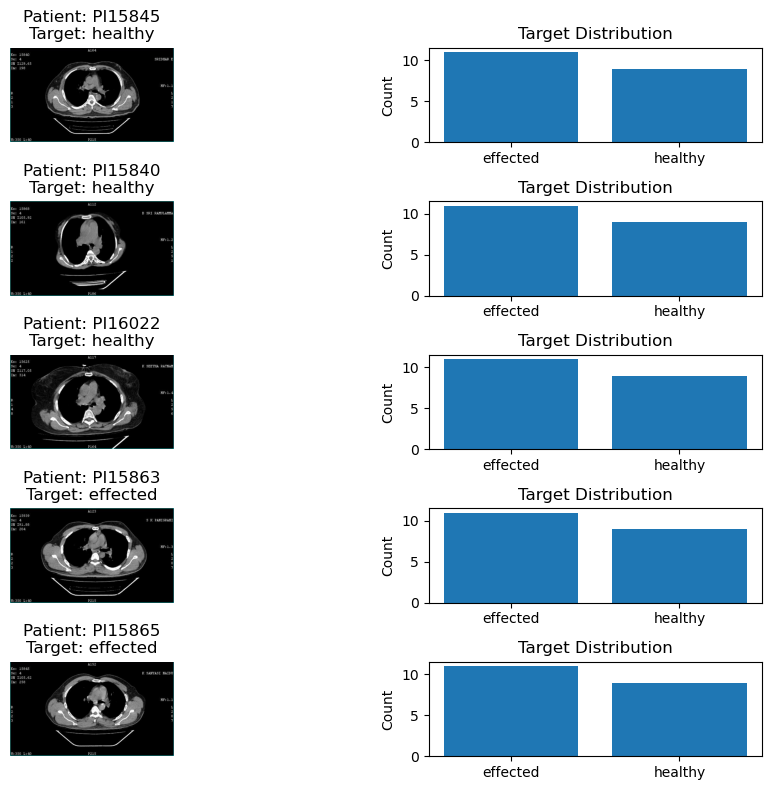

In [3]:
# Data Visualization
num_samples = 5  # Number of samples to display
sample_data = df.sample(num_samples)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(num_samples, 2, width_ratios=[3, 1])

for i, (_, row) in enumerate(sample_data.iterrows()):
    ax0 = plt.subplot(gs[i, 0])
    image = plt.imread(row['Image path'])
    ax0.imshow(image)
    ax0.set_title(f"Patient: {row['Patient']}\nTarget: {row['target']}")
    ax0.axis('off')

    ax1 = plt.subplot(gs[i, 1])
    target_counts = df['target'].value_counts()
    ax1.bar(target_counts.index, target_counts.values)
    ax1.set_title('Target Distribution')
    ax1.set_ylabel('Count')

plt.tight_layout()
plt.savefig('Target Distribution.png')
plt.show()

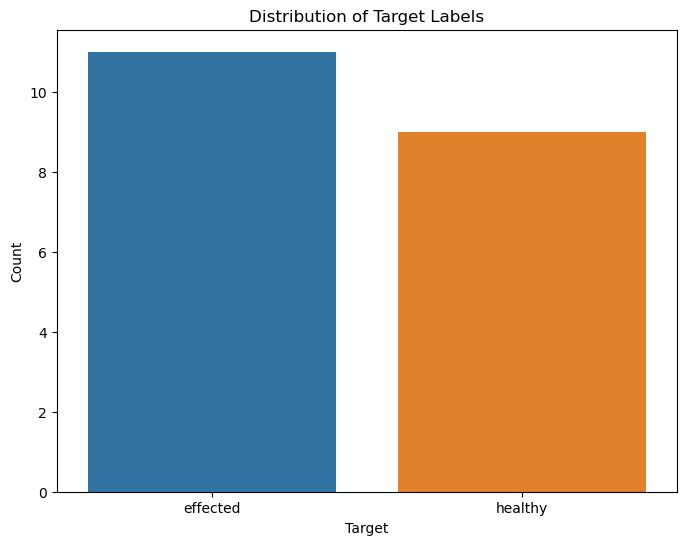

In [4]:
# Analyze Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Labels')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('Distribution of Target Labels.png')
plt.show()

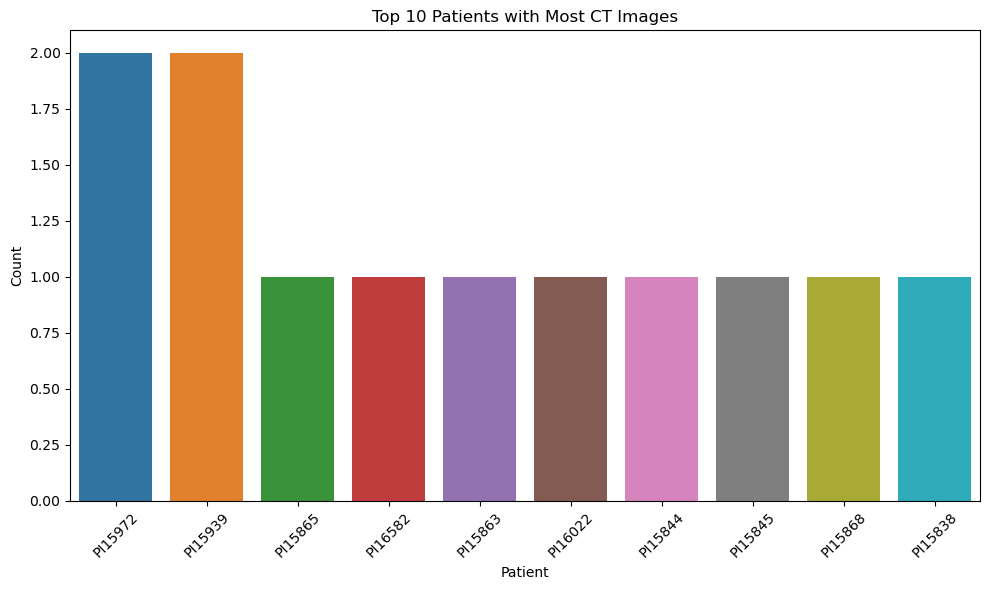

In [5]:
# Analyze Patient Distribution
plt.figure(figsize=(10, 6))
top_patients = df['Patient'].value_counts()[:10]
sns.barplot(x=top_patients.index, y=top_patients.values)
plt.title('Top 10 Patients with Most CT Images')
plt.xlabel('Patient')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Top 10 Patients with Most CT Images.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

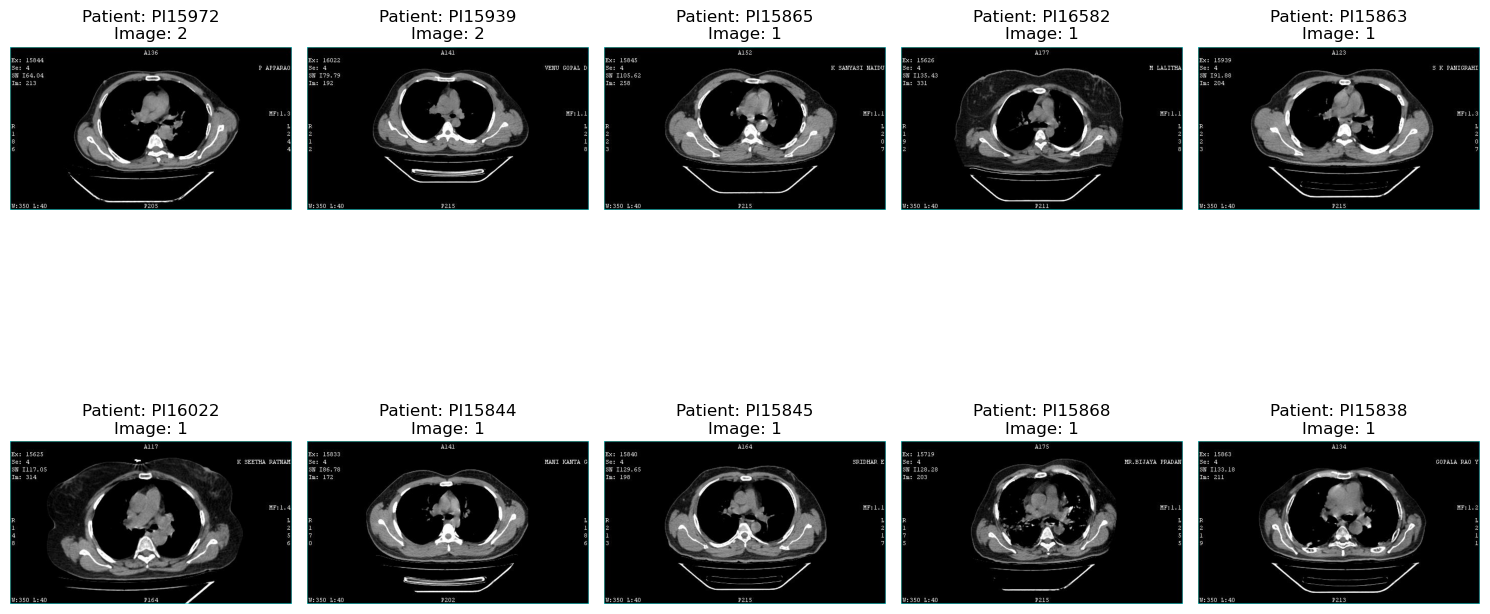

In [6]:
# Analyze Patient Distribution
plt.figure(figsize=(12, 8))
top_patients = df['Patient'].value_counts()[:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
axes = axes.flatten()

for i, (patient, count) in enumerate(top_patients.iteritems()):
    ax = axes[i]
    patient_images = df[df['Patient'] == patient]['Image path'].sample(min(count, 5))
    for j, image_path in enumerate(patient_images):
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(f"Patient: {patient}\nImage: {j+1}")
        ax.axis('off')
    if i == len(top_patients)-1:
        break

plt.tight_layout()
plt.savefig('Top 10 Patient CT Image.png')
plt.show()

# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b></b>Prepare Data for Model Training</p></div>


In [7]:
# Prepare data for model training
encoder = LabelEncoder()
df['target_encoded'] = encoder.fit_transform(df['target'])


# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b></b>Split the Data</p></div>


In [8]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target_encoded'], random_state=42)


# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b></b>Define Image Preprocessing</p></div>


In [9]:
# Define image preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    image = imread(image_path)  # Load image using skimage
    image = transform.resize(image, target_size)  # Resize the image
    
    # Apply histogram equalization to each color channel
    equalized_channels = [exposure.equalize_hist(channel) for channel in image.transpose((2, 0, 1))]
    equalized_image = np.stack(equalized_channels, axis=-1)
    
    processed_image = equalized_image.flatten()  # Flatten the image
    return processed_image


# <div style="color:yellow;display:inline-block;border-radius:5px;background-color:#F94144;font-family:Nexa;overflow:hidden"><p style="padding:15px;color:yellow;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0"><b></b>Model Training and Evaluation</p></div>


In [10]:
# Model training and evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Preprocess images
    train_features = np.array([preprocess_image(image_path) for image_path in train_df['Image path']])
    test_features = np.array([preprocess_image(image_path) for image_path in test_df['Image path']])
    
    # Train the model
    model.fit(train_features, train_df['target_encoded'])
    
    # Make predictions on the test set
    predictions = model.predict(test_features)
    
    # Evaluate the model
    accuracy = accuracy_score(test_df['target_encoded'], predictions)
    f1 = f1_score(test_df['target_encoded'], predictions)
    
    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(test_df['target_encoded'], predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

Training Logistic Regression...
Logistic Regression Evaluation:
Accuracy: 0.50
F1 Score: 0.00
Confusion Matrix:
[[2 0]
 [2 0]]
Training Random Forest...
Random Forest Evaluation:
Accuracy: 0.50
F1 Score: 0.00
Confusion Matrix:
[[2 0]
 [2 0]]
Training XGBoost...
XGBoost Evaluation:
Accuracy: 0.75
F1 Score: 0.67
Confusion Matrix:
[[2 0]
 [1 1]]


Classification Report:
              precision    recall  f1-score   support

    effected       0.67      1.00      0.80         2
     healthy       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



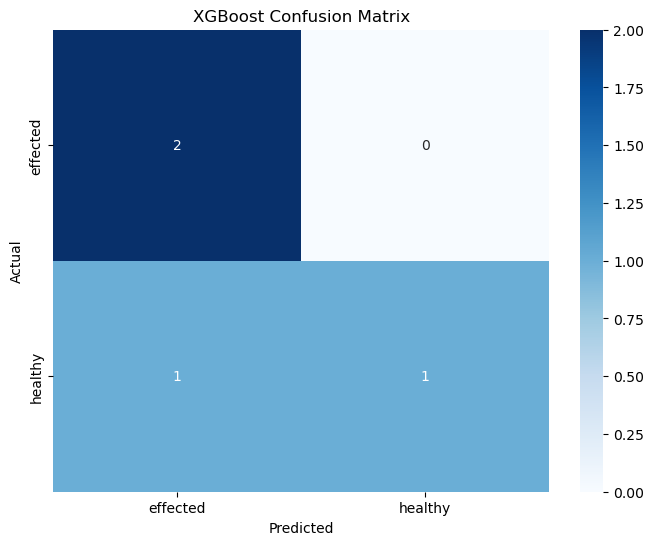

In [11]:
# Classification Report
class_report = classification_report(test_df['target_encoded'], predictions, target_names=encoder.classes_)
print("Classification Report:")
print(class_report)
    
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f'{model_name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Confusion Matrix.png')
plt.show()

<div class="alert alert-block alert-info"> 📌 "Hey there! Your positive feedback and support for my notebook mean the world to me! It motivates me to create more valuable content. If you can spare a moment to give it an upvote, it would help others discover and benefit from it too. Together, let's foster a vibrant community of knowledge-sharing and empowerment. Thank you for considering it, and continued success on your learning journey!"😃</div>